# Metro Interstate Traffic Volume dataset
- https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

- Target Variable: Traffic Volume (traffic_volume)
- All other columns are features        

## Organization
- 0. Imports
- 1. EDA
- 2. Define extrapolation regions
- 3. Train/test splits
- 4. Feature Selection
- 5. Training, Tuning, and Eval
- 6. Extrapolation
- 7. Visualizations, explanations, conclusions, etc.

# 0.0 Imports
### 0.1 Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import zipfile

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

asset_dir = '/project_data/data_asset/'

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

### 0.2 Data

In [2]:
metro_traffic = wslib.load_data('Metro_Interstate_Traffic_Volume.csv.gz')

df_traffic = pd.read_csv(metro_traffic, parse_dates=['date_time'], compression='gzip')
df_traffic = df_traffic.loc[(df_traffic['weather_main']!='Squall') & (df_traffic['weather_main']!='Smoke')]
df_traffic['hour'] = df_traffic['date_time'].dt.hour
df_traffic['day_of_week'] = df_traffic['date_time'].dt.dayofweek
df_traffic['day_of_week'] = df_traffic['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
df_traffic['is_holiday'] = np.where((df_traffic['holiday']=='None'), 0, 1)
df_traffic['is_holiday'] = df_traffic['is_holiday'].astype(bool)
df_traffic = df_traffic.set_index('date_time')
print(df_traffic.shape)
df_traffic.head()



(48180, 11)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day_of_week,is_holiday
date_time,,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9,Tuesday,False
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10,Tuesday,False
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11,Tuesday,False
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12,Tuesday,False
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13,Tuesday,False


### 0.3 Helper Functions


In [3]:
# helper functions

def examine_data_regions(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Examine the data according to desired experimentation splits using percentiles for train/test and extrapolation
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            The shape of pandas dataframe for the extrapolation region
            The mean value of the target for the intended train/test data
            The mean value of the target for the extrapolation region
    '''
    
    shape    = df.loc[df[target] >= df[target].quantile(extrapolate_percentile)].shape
    
    mean_is  = df.loc[df[target] <= df[target].quantile(train_test_percentile)][target].mean()
    mean_oos = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].mean()
    
    return shape, mean_is, mean_oos


def violin_dist_plots(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=ax1)
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax1)

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=ax2)
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=ax3)

    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True)

    ax1.set_title(title)
    ax2.set_title('Data used for training & testing')
    ax3.set_title('Data used for extrapolation')
    plt.xlabel(variable_name)
    plt.tight_layout()
    plt.show()


def violin_dist_plots_2(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=axes[0])
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=axes[0], label='Outliers')

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=axes[1])
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=axes[2])

    axes[0].tick_params(labelbottom=True)
    axes[1].tick_params(labelbottom=True)

    axes[0].set_title(title)
    axes[1].set_title('Data used for training & testing')
    axes[2].set_title('Data used for extrapolation')
    plt.tight_layout()
    plt.xlabel(variable_name)
    axes[0].legend()
    plt.show()


def train_test_extrapolation_split(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Split the data. 
    First, separate the data into to bins; one for training/testing, and one for extrapolation. 
    Next, create the 75/25 train/test split using scikit-learn function. 
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            X and y data (pandas dataframes) for Training
            X and y data (pandas dataframes) for Testing
            X and y data (pandas dataframes) for Extrapolation
    '''
    
    insample_X = df.loc[df[target] <=  df[target].quantile(train_test_percentile)].drop([target], axis=1)
    insample_y = df.loc[df[target] <=  df[target].quantile(train_test_percentile)][target]
    
    X_train, X_test, y_train, y_test = train_test_split(insample_X, insample_y, test_size=.25, random_state=12)
    
    X_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)].drop([target], axis=1)
    y_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target]
    
    return X_train, y_train, X_test, y_test, X_extrapolate, y_extrapolate 


def correlation_heatmap(data, features, annot=True):
    '''
    Plot a heatmap of the feature set
        Parameters:
            data (pandas dataframe): pandas dataframe of the feature set
            features (list): list of names to be included in the plot 
    '''
    fig, ax = plt.subplots(figsize=(13,13)) 
    fig = sns.heatmap(data[features].corr(), vmin=-1, vmax=1, center=0,
                     cmap=sns.diverging_palette(20, 220, n=200),
                     square=True,
                     annot=annot, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    
def evaluations_lr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Linear Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    
    print('Linear Regression results on Train/Test')
    print('Number of features: ', model['linearregression'].n_features_in_)

    # train RMSE
    y_pred_tr = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred_tr, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred_te = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred_te, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred_ex = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred_ex, squared=False)

#     print(f'Extrapolation set RMSE: {extrapolation_rmse: .4f}')
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_rfr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Random Forest Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Random Forest results on Train/Test')
    print(model['randomforestregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')
    
    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')

    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse
        
def evaluations_dtr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Decision Tree Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Decision Tree results on Train/Test')
    print(model['decisiontreeregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')  
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_hgbr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Histogram Gradient Boosting Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Hist Grad Booster results on Train/Test')
    print(model['histgradientboostingregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse


def plot_rmse_train_test(rmse_dict, split_number):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training and testing sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train, width, label='Training')
    rects2 = ax.bar(x + width/2, test , width, label='Testing')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Traffic Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
    ax.set_yticks(np.arange(0,2500,500))
    ax.legend()

    ax.bar_label(rects1, padding=2)
    ax.bar_label(rects2, padding=2)

    fig.tight_layout()

    plt.show()
    
    
def plot_rmse_train_test_extrap(rmse_dict, split_number):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''   
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]
    extrap = [round(c, 1) for c in rmse_dict['Extrapolation']]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, train , width, label='Training')
    rects2 = ax.bar(x        , test  , width, label='Testing')
    rects3 = ax.bar(x + width, extrap, width, label='Extrapolation')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Traffic Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
    ax.set_yticks(np.arange(0,4000,500))
    ax.legend(loc=1)

#    # commenting out because they are difficukt to read
#     ax.bar_label(rects1, padding=2)
#     ax.bar_label(rects2, padding=2)
#     ax.bar_label(rects3, padding=2)

    fig.tight_layout()

    plt.show()
    

def plot_relative_perf(rmse_dict, use_case, y_ticks=np.arange(0, 4,.5)):
    '''
    Plot relative performance change between the extrapolation and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            use_case (string or int): The name of the use case, used for the title
    '''   
    fig, ax = plt.subplots()
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    performance_decreases = [round(i / j, 2) for i, j in zip(rmse_dict['Extrapolation'], rmse_dict['Test'])]

    bars = ax.bar(labels, performance_decreases, width=.4, color='purple')
    ax.bar_label(bars)

    ax.set_yticks(y_ticks)
    plt.xlabel('Model')
    plt.ylabel('Extrapolation RMSE / Test RMSE')
    plt.title(f'Relative Performance Decline by Model in Extrapolation \n {use_case}')
    plt.show()


# 1.0 Exploratory Data Analysis

In [4]:
# print the value counts of the weather_main column
display(df_traffic['weather_main'].value_counts())

# there are enough categories to work with here, so I will drop the weather_description column

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Name: weather_main, dtype: int64

In [5]:
# for now I will exclude the 'weather_description' column

df_traffic = df_traffic.drop(['weather_description', 'holiday'], axis=1)
df_traffic.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,hour,day_of_week,is_holiday
date_time,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,Clouds,5545,9,Tuesday,False
2012-10-02 10:00:00,289.36,0.0,0.0,75,Clouds,4516,10,Tuesday,False
2012-10-02 11:00:00,289.58,0.0,0.0,90,Clouds,4767,11,Tuesday,False
2012-10-02 12:00:00,290.13,0.0,0.0,90,Clouds,5026,12,Tuesday,False
2012-10-02 13:00:00,291.14,0.0,0.0,75,Clouds,4918,13,Tuesday,False


In [6]:
# check if there are any missing values in any column

df_traffic.isna().any().value_counts()

False    9
dtype: int64

# 2.0 Define Extrapolation Regions

### 2.1 Standard Split
- Train/Test: [0-90]
- Extrapolate: (90-100]

Number of rows >= 90.0 percentile: 4819
Mean of target in train/test region:  2928.0608
Mean of target in extrapolation region:  6249.4807


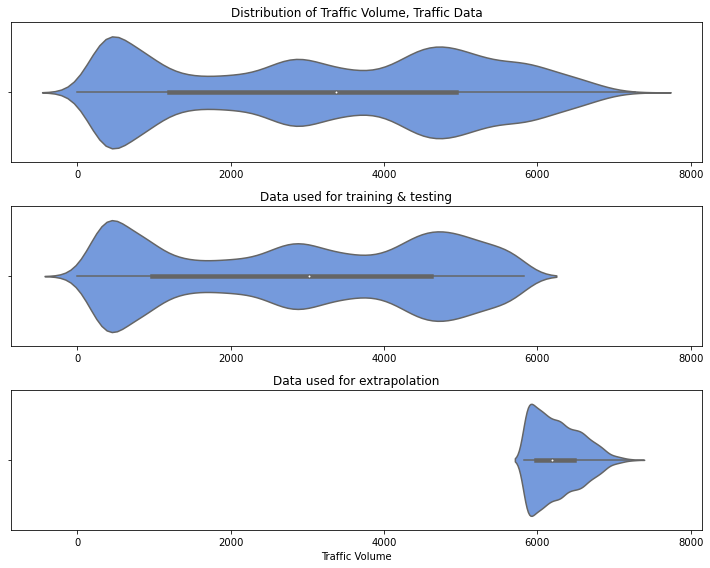

In [7]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex0 = .90
split_percentile_extrap_ex0 = .90


shape_0, mean_is_0, mean_oos_0 = examine_data_regions(df_traffic, 'traffic_volume', split_percentile_train_test_ex0, split_percentile_extrap_ex0)

print(f'Number of rows >= {split_percentile_extrap_ex0*100} percentile: {shape_0[0]}')
print(f'Mean of target in train/test region: {mean_is_0: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_0: .4f}')


violin_dist_plots(df_traffic, 
                  'traffic_volume', 
                  split_percentile_train_test_ex0, 
                  split_percentile_extrap_ex0, 
                  'Distribution of Traffic Volume, Traffic Data', 
                  'Traffic Volume')

### 2.2 Experiment Split 1 (low)
- Train/Test: [0-80]
- Leave out: (80-90]
- Extrapolate: (90-100]

Number of rows >= 91.0 percentile: 4345
Mean of target in train/test region:  2607.4321
Mean of target in extrapolation region:  6293.5579


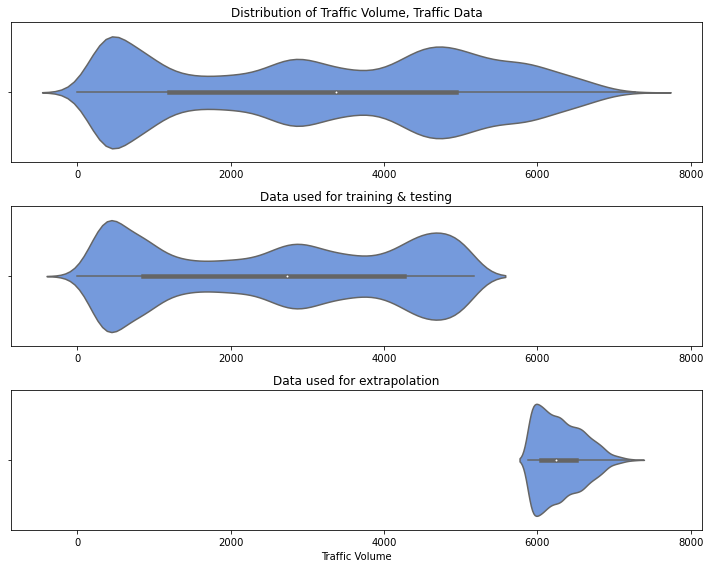

In [8]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex1 = .80
split_percentile_extrap_ex1 = .91


shape_1, mean_is_1, mean_oos_1 = examine_data_regions(df_traffic, 'traffic_volume', split_percentile_train_test_ex1, split_percentile_extrap_ex1)

print(f'Number of rows >= {split_percentile_extrap_ex1*100} percentile: {shape_1[0]}')
print(f'Mean of target in train/test region: {mean_is_1: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_1: .4f}')



violin_dist_plots(df_traffic, 
                  'traffic_volume', 
                  split_percentile_train_test_ex1, 
                  split_percentile_extrap_ex1, 
                  'Distribution of Traffic Volume, Traffic Data', 
                  'Traffic Volume')

### 2.3 Experiment Split 2 (moderate)
- Train/Test: [0-70]
- Leave out: (70-85]
- Extrapolate: (85-100]

Number of rows >= 86.0 percentile: 6753
Mean of target in train/test region:  2274.7341
Mean of target in extrapolation region:  6089.1760


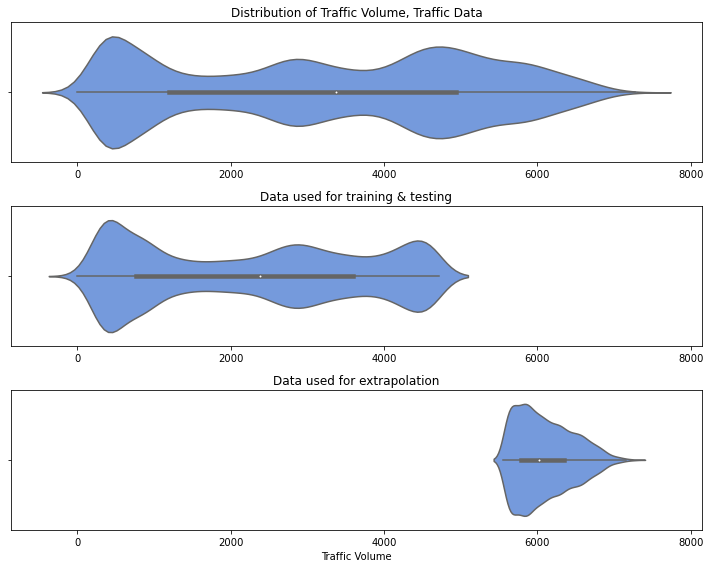

In [9]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex2 = .70
split_percentile_extrap_ex2 = .86

shape_2, mean_is_2, mean_oos_2 = examine_data_regions(df_traffic, 'traffic_volume', split_percentile_train_test_ex2, split_percentile_extrap_ex2)

print(f'Number of rows >= {split_percentile_extrap_ex2*100} percentile: {shape_2[0]}')
print(f'Mean of target in train/test region: {mean_is_2: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_2: .4f}')



violin_dist_plots(df_traffic, 
                  'traffic_volume', 
                  split_percentile_train_test_ex2, 
                  split_percentile_extrap_ex2, 
                  'Distribution of Traffic Volume, Traffic Data', 
                  'Traffic Volume')

### 2.4 Experiment Split 3 (extreme)
- Train/Test: [0-60]
- Leave out: (60-90]
- Extrapolate: (90-100]

Number of rows >= 95.0 percentile: 2412
Mean of target in train/test region:  1903.6657
Mean of target in extrapolation region:  6507.3774


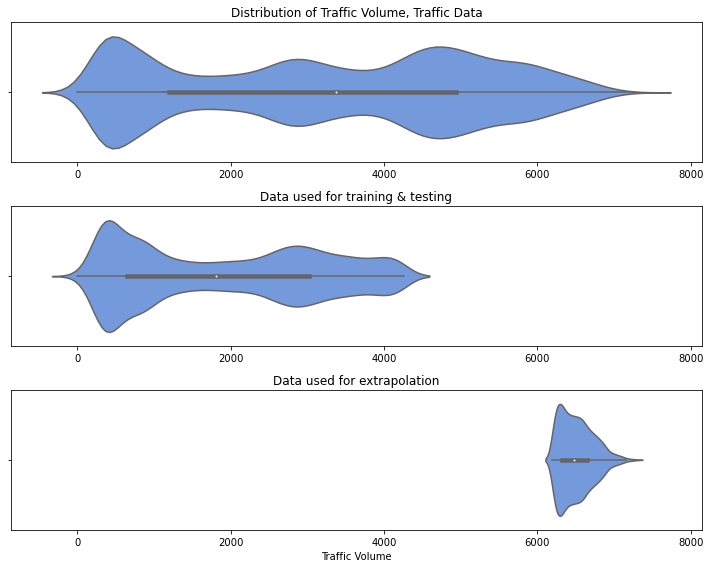

In [10]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex3 = .60
split_percentile_extrap_ex3 = .95

shape_3, mean_is_3, mean_oos_3 = examine_data_regions(df_traffic, 'traffic_volume', split_percentile_train_test_ex3, split_percentile_extrap_ex3)

print(f'Number of rows >= {split_percentile_extrap_ex3*100} percentile: {shape_3[0]}')
print(f'Mean of target in train/test region: {mean_is_3: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_3: .4f}')



violin_dist_plots(df_traffic, 
                  'traffic_volume', 
                  split_percentile_train_test_ex3, 
                  split_percentile_extrap_ex3, 
                  'Distribution of Traffic Volume, Traffic Data', 
                  'Traffic Volume')

# 3.0 Train/Test/Extrapolation Splits

In [11]:
# standard split

X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0 = train_test_extrapolation_split(df_traffic, 'traffic_volume', .9, .91)

print(X_train_0.shape)
print(X_test_0.shape)
print(X_extrap_0.shape)

(32524, 8)
(10842, 8)
(4336, 8)


In [12]:
# experiment 1 -- low 
X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1 = train_test_extrapolation_split(df_traffic, 'traffic_volume', .8, .91)

print(X_train_1.shape)
print(X_test_1.shape)
print(X_extrap_1.shape)

(28908, 8)
(9636, 8)
(4336, 8)


In [13]:
# experiment 2 -- moderate

X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2 = train_test_extrapolation_split(df_traffic, 'traffic_volume', .7, .86)

print(X_train_2.shape)
print(X_test_2.shape)
print(X_extrap_2.shape)

(25298, 8)
(8433, 8)
(6745, 8)


In [14]:
# experiment 3 -- extreme

X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3 = train_test_extrapolation_split(df_traffic, 'traffic_volume', .6, .95)

print(X_train_3.shape)
print(X_test_3.shape)
print(X_extrap_3.shape)

(21683, 8)
(7228, 8)
(2406, 8)


# 4.0 Feature Selection

### 4.1 Find the set of uncorrelated columns

In [15]:
# find uncorrelated columns

corr_matrix = X_train_3[[c for c in X_train_3.select_dtypes('number').columns]].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print('Number of columns to remove: ', len(to_drop))
print('\n')
print(to_drop)

Number of columns to remove:  0


[]


### Plot the heatmap to visualize this

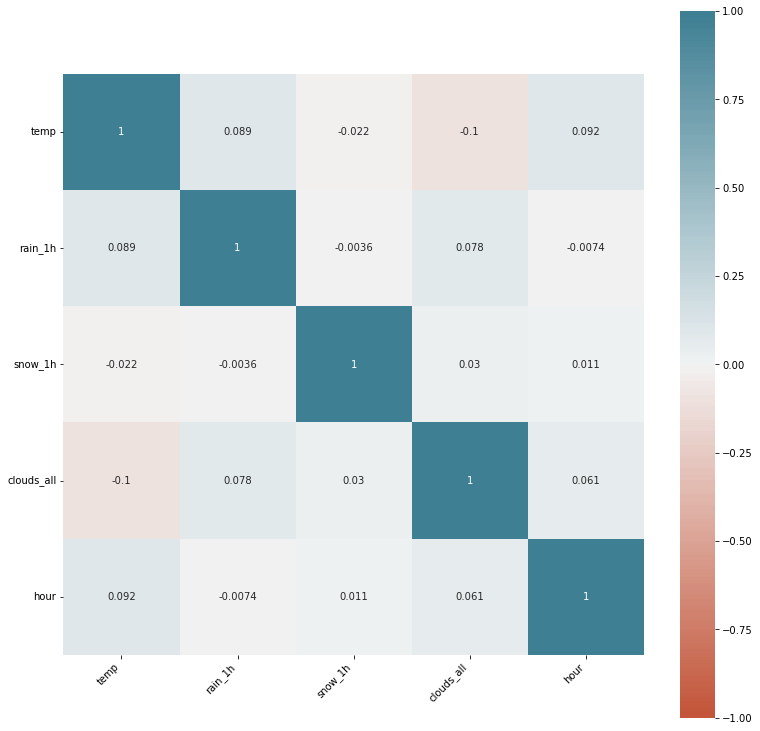

In [16]:
# correlation_heatmap(df_spr, list(selector.get_feature_names_out())+['critical_temp'])
# # need to drop columns that are to_drop

correlation_heatmap(X_train_3, [c for c in X_train_3.select_dtypes('number').columns])


### 4.2 Check the mutual information

In [17]:
mi = mutual_info_regression(X_train_3[[c for c in upper_tri.columns if c not in to_drop]], y_train_3)

mutual_info = pd.DataFrame(index=X_train_3[[c for c in upper_tri.columns if c not in to_drop]].columns, 
                           data={'Mutual_info': mi}).sort_values(by='Mutual_info', ascending=False)

# get some general information about the mutual information
mutual_info.describe()


,Mutual_info
count,5.000000
mean,0.325346
std,0.498136
min,0.001041
25%,0.037911
50%,0.096020
75%,0.299514
max,1.192241


# 5.0 Training, Tuning, Evaluation

- Note: Some of the grid search is commented out after finding the best features to make rerunning faster

In [18]:
target = ['traffic_volume']
features = [c for c in df_traffic.columns if c not in target]

bool_feats = [c for c in features if X_train_0[c].dtype==bool]
num_feats = [c for c in X_train_0.select_dtypes('number').columns]
cat_feats = [c for c in features if c not in target+to_drop+bool_feats+num_feats]

In [19]:
def define_preprocessor(num_feats, cat_feats, binary_feats):
    
    num_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
    
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))
    
#     binary_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())   
    binary_pipe = make_pipeline(OrdinalEncoder(), SimpleImputer(strategy='most_frequent'))
    # need to encode first because the imputing bool data is not supported
    
    preprocessor = make_column_transformer((num_pipe, num_feats), 
                                           (cat_pipe, cat_feats), 
                                           (binary_pipe, binary_feats), 
                                           remainder='drop')
    
    return preprocessor

In [20]:
my_preprocessor = define_preprocessor(num_feats, cat_feats, bool_feats)
my_preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['temp', 'rain_1h', 'snow_1h', 'clouds_all',
                                  'hour']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['weather_main', 'day_of_week']),
                                ('pipeline-3',
                                 Pipeline(steps=[('ordinalencoder',
   

### 5.1 Linear Regression

In [21]:
# standard case

# define the model
lr_model_0 = LinearRegression()
pipe_lr_0 = make_pipeline(my_preprocessor, lr_model_0)

# fit the model
pipe_lr_0.fit(X_train_0, y_train_0)

# get some eval information
train_rmse_lr_0, test_rmse_lr_0, extrapolation_rmse_lr_0 = evaluations_lr(pipe_lr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Linear Regression results on Train/Test
Number of features:  22
Train set RMSE:  1615.3449
Test set RMSE:  1617.9589


[  186.63761518     9.72877122    -4.93626099   122.09390733
   666.13041832    75.56540694   239.77042619   -70.35902806
  -290.37214941   486.55966258  -102.36138667   -41.89929719
    33.03727191  -329.9409063    390.05571623   -25.28872504
  -176.3045475   -594.01360935   163.43310048    99.29679952
   142.82126567 -1061.36033507]


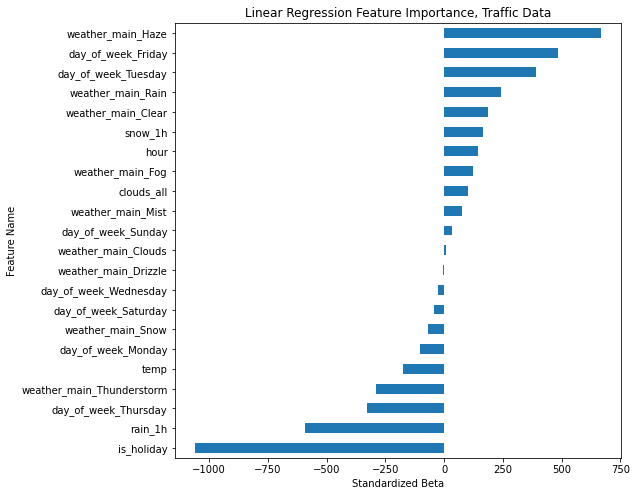

In [22]:
# get feature importances
# standard case
print(pipe_lr_0.steps[1][1].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(pipe_lr_0.steps[1][1].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Traffic Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [23]:
### first case

# define the model
lr_model_1 = LinearRegression()
pipe_lr_1 = make_pipeline(my_preprocessor, lr_model_1)

# fit the model
pipe_lr_1.fit(X_train_1, y_train_1)

# get some eval information
# train_rmse_lr_1, test_rmse_lr_1 = evaluations_lr(best_model_lr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_lr_1, test_rmse_lr_1, extrapolation_rmse_lr_1 = evaluations_lr(pipe_lr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Linear Regression results on Train/Test
Number of features:  22
Train set RMSE:  1442.4910
Test set RMSE:  1434.7815


[ 164.94309121  -15.3724917    -7.74010787  133.23155362  734.02350258
  100.99178979  237.09420663  -77.27112688 -317.92489261  473.23484604
 -171.01827102  -20.99415092   92.23238772 -316.34478874   94.87877956
  -23.67956769   96.4560887  -258.54973562   38.24349566   39.03542087
   13.61551852 -540.14249729]


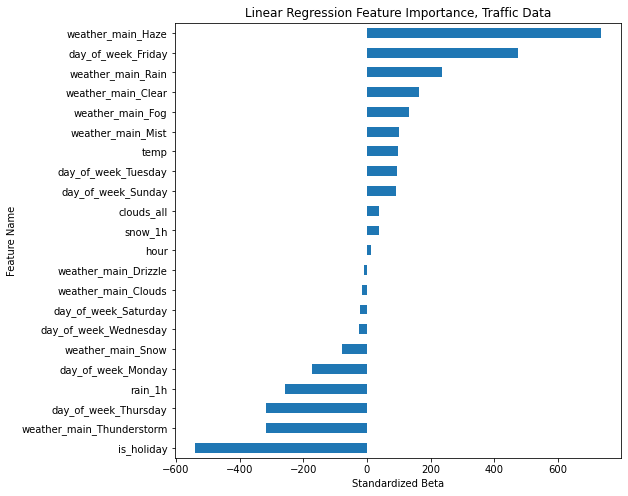

In [24]:
# get feature importances
# standard case
print(pipe_lr_1.steps[1][1].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(pipe_lr_1.steps[1][1].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Traffic Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [25]:
# second case

# define the model
lr_model_2 = LinearRegression()
pipe_lr_2 = make_pipeline(my_preprocessor, lr_model_2)

# fit the model
pipe_lr_2.fit(X_train_2, y_train_2)

# get some eval information
# train_rmse_lr_2, test_rmse_lr_2 = evaluations_lr(best_model_lr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_lr_2, test_rmse_lr_2, extrapolation_rmse_lr_2 = evaluations_lr(pipe_lr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)



Linear Regression results on Train/Test
Number of features:  22
Train set RMSE:  1255.3205
Test set RMSE:  1257.4783


[ 132.98685385  -33.34250773  -25.95140978  104.29660301  760.59082303
   77.79987431  174.03598037  -46.19510406 -246.57748141  291.48311641
 -117.14461073  -34.91317071  101.89558367 -200.38418785  -54.60532893
   11.25255434  275.71051271   34.60757655 -114.10184602  -62.0896753
  -90.77379335 -287.5483173 ]


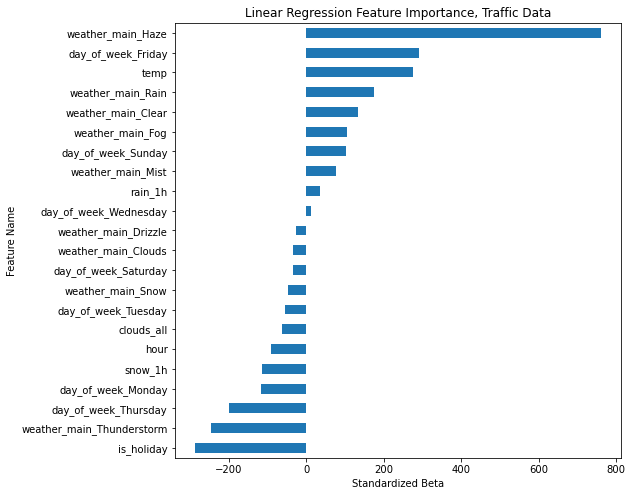

In [26]:
# get feature importances
# standard case
print(pipe_lr_2.steps[1][1].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(pipe_lr_2.steps[1][1].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Traffic Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [27]:
# third case

# define the model
lr_model_3 = LinearRegression()
pipe_lr_3 = make_pipeline(my_preprocessor, lr_model_3)

# fit the model
pipe_lr_3.fit(X_train_3, y_train_3)

# get some eval information
# train_rmse_lr_3, test_rmse_lr_3 = evaluations_lr(best_model_lr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_lr_3, test_rmse_lr_3, extrapolation_rmse_lr_3 = evaluations_lr(pipe_lr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)



Linear Regression results on Train/Test
Number of features:  22
Train set RMSE:  1010.3134
Test set RMSE:  1023.1486


[  83.35505508  -31.98789711  -11.26187605   63.82648664  760.3673767
   15.33325631   82.30088966  -78.18871063 -110.52154789  268.45573582
  -98.58645726  -74.54242441   85.50719701  -89.75793861    8.20003912
  -64.8615452   319.74672341  151.33100979  -89.59514444 -136.61389136
 -188.20719132   40.50422178]


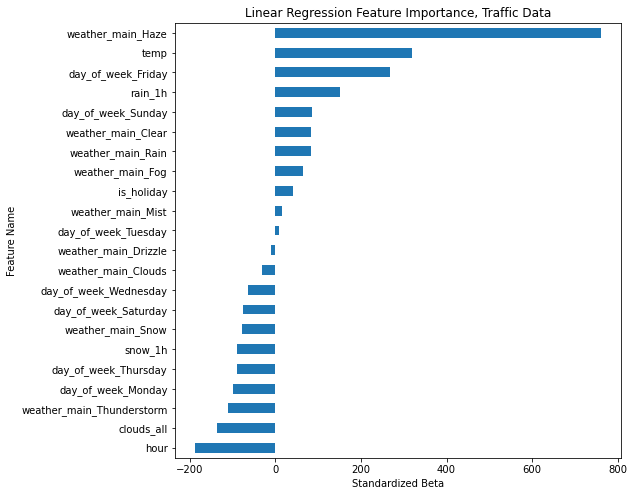

In [28]:
# get feature importances
# standard case
print(pipe_lr_3.steps[1][1].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(pipe_lr_3.steps[1][1].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Traffic Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


### 5.2 Random Forest Regressor

In [29]:
# define the model

rfr_model = RandomForestRegressor(criterion='squared_error', random_state=12)
pipe_rfr = make_pipeline(my_preprocessor, rfr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)


In [30]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(100, 120, 3)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(6,10,3)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(6,12,4)).astype(int)}


# best params
param_grid = {'randomforestregressor__n_estimators':[110],
              'randomforestregressor__max_depth':[10], 
              'randomforestregressor__min_samples_leaf':[6]}


grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_0 = grid_rfr.best_estimator_

# train_rmse_rfr_0, test_rmse_rfr_0 = evaluations_rfr(best_model_rfr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_rfr_0, test_rmse_rfr_0, extrapolation_rmse_rfr_0 = evaluations_rfr(best_model_rfr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9343
Best parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 6, 'randomforestregressor__n_estimators': 110}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=10, min_samples_leaf=6, n_estimators=110,
                      random_state=12)
Train set RMSE:  437.3181
Test set RMSE:  463.7754


[1.01873484e-02 1.46386847e-03 2.83816295e-05 1.69869054e-03
 8.86366354e-01 9.37191815e-05 5.18113317e-04 1.05325191e-05
 1.42332199e-04 4.05459151e-05 2.32723185e-04 6.00365959e-05
 1.32912620e-04 3.91330675e-05 2.72761816e-03 3.47915141e-03
 3.81720828e-02 5.35270265e-02 5.68810069e-04 3.34751956e-04
 1.53721508e-04 2.21460269e-05]


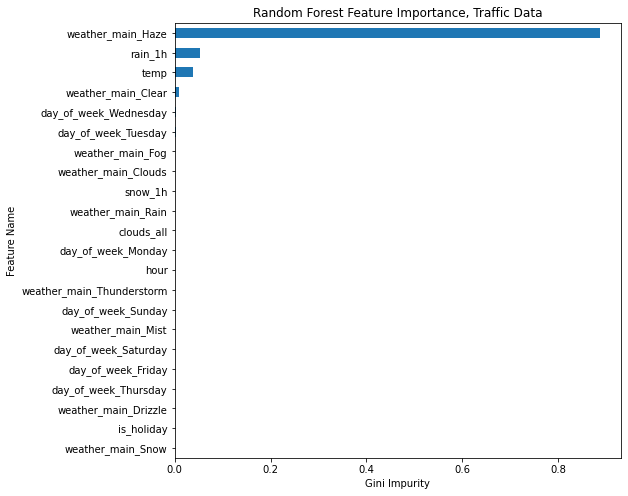

In [31]:
# standard case

print(best_model_rfr_0.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_rfr_0.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [32]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(85, 110, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(7,14,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(8,14,3)).astype(int)}


# best params
param_grid = {'randomforestregressor__n_estimators':[110],
              'randomforestregressor__max_depth':[14], 
              'randomforestregressor__min_samples_leaf':[8]}


grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_1 = grid_rfr.best_estimator_

# train_rmse_rfr_1, test_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_rfr_1, test_rmse_rfr_1, extrapolation_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9354
Best parameters: {'randomforestregressor__max_depth': 14, 'randomforestregressor__min_samples_leaf': 8, 'randomforestregressor__n_estimators': 110}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=14, min_samples_leaf=8, n_estimators=110,
                      random_state=12)
Train set RMSE:  368.3117
Test set RMSE:  414.2434


[1.72595477e-02 2.10386633e-03 0.00000000e+00 3.22170901e-03
 9.08697731e-01 2.93093440e-04 1.21528289e-03 1.03153853e-05
 3.75281754e-04 4.16340288e-05 3.84171807e-04 1.12362054e-04
 2.39012599e-04 5.58612560e-05 3.39340768e-03 3.24047485e-03
 2.53610495e-02 3.19954124e-02 9.83673494e-04 6.47434172e-04
 3.26408229e-04 4.22707659e-05]


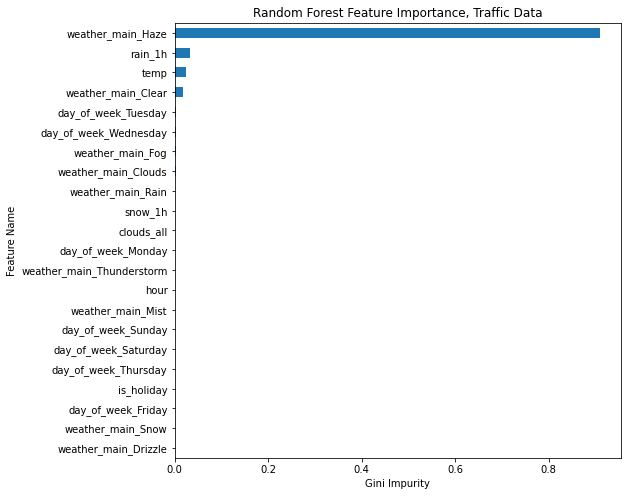

In [33]:
# first case

print(best_model_rfr_1.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_rfr_1.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [34]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(90, 105, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(8,16,5)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(6,10,3)).astype(int)}


# best params
param_grid = {'randomforestregressor__n_estimators':[101],
              'randomforestregressor__max_depth':[16], 
              'randomforestregressor__min_samples_leaf':[6]}


grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_2 = grid_rfr.best_estimator_

# train_rmse_rfr_2, test_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_rfr_2, test_rmse_rfr_2, extrapolation_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9280
Best parameters: {'randomforestregressor__max_depth': 16, 'randomforestregressor__min_samples_leaf': 6, 'randomforestregressor__n_estimators': 101}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=16, min_samples_leaf=6, n_estimators=101,
                      random_state=12)
Train set RMSE:  333.3952
Test set RMSE:  382.3834


[2.32703408e-02 2.23814578e-03 0.00000000e+00 3.79562572e-03
 9.01425165e-01 4.84103244e-04 1.56035142e-03 2.40449764e-05
 5.43721197e-04 2.62752933e-04 6.81518675e-04 2.17942550e-04
 3.67733109e-04 6.60406911e-05 4.59079307e-03 3.05328295e-03
 2.49684205e-02 2.94218906e-02 1.60759033e-03 7.44278359e-04
 6.39565650e-04 3.66921069e-05]


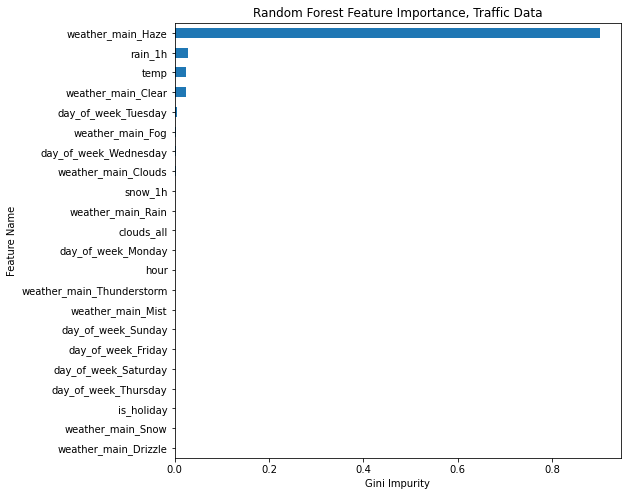

In [35]:
# second case

print(best_model_rfr_2.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_rfr_2.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [36]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(90, 110, 4)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(10,14,3)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(14,18,3)).astype(int)}


# best params
param_grid = {'randomforestregressor__n_estimators':[110],
              'randomforestregressor__max_depth':[12], 
              'randomforestregressor__min_samples_leaf':[14]}


grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_3 = grid_rfr.best_estimator_

# train_rmse_rfr_3, test_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_rfr_3, test_rmse_rfr_3, extrapolation_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9154
Best parameters: {'randomforestregressor__max_depth': 12, 'randomforestregressor__min_samples_leaf': 14, 'randomforestregressor__n_estimators': 110}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=12, min_samples_leaf=14, n_estimators=110,
                      random_state=12)
Train set RMSE:  347.2354
Test set RMSE:  379.6915


[1.55580191e-02 2.30849147e-03 0.00000000e+00 2.51146317e-03
 9.00135029e-01 3.25618260e-04 7.68504954e-04 5.28771192e-06
 4.19812625e-04 4.53480082e-05 2.92168978e-04 6.86582709e-05
 2.61001061e-04 3.52265962e-05 6.79829212e-03 4.20290824e-03
 2.74323545e-02 3.54226232e-02 2.06943104e-03 8.11166377e-04
 4.89673760e-04 3.89214400e-05]


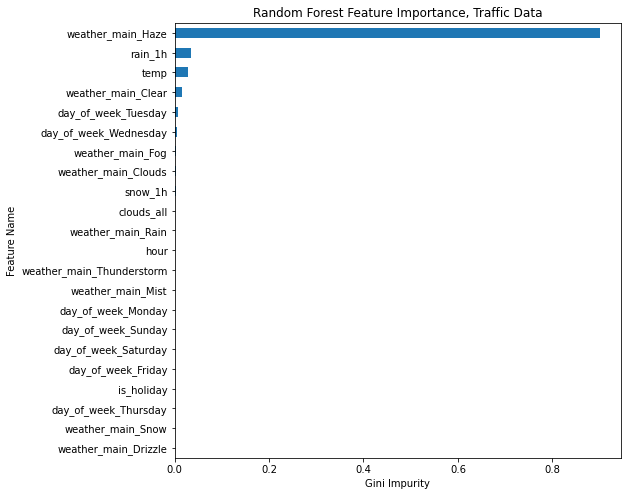

In [37]:
# third case

print(best_model_rfr_3.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_rfr_3.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


### 5.3 Decision Tree Model

In [38]:
# define the model

dtr_model = DecisionTreeRegressor(criterion='squared_error', random_state=12)
pipe_dtr = make_pipeline(my_preprocessor, dtr_model)

kfold = KFold(n_splits=5, shuffle=True, random_state=12)



In [39]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,10,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(25,45,6)).astype(int)}

# best params
param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[29]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_0 = grid_dtr.best_estimator_

# train_rmse_dtr_0, test_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_dtr_0, test_rmse_dtr_0, extrapolation_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9306


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=29, random_state=12)
Train set RMSE:  461.3307
Test set RMSE:  485.6563


[7.65606578e-03 3.75210008e-04 0.00000000e+00 1.20290831e-03
 8.90774084e-01 1.23394517e-05 3.42221710e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.70227617e-05 1.48995526e-05
 0.00000000e+00 0.00000000e+00 2.76904424e-03 3.78976140e-03
 3.82545269e-02 5.37146051e-02 5.85202127e-04 2.15651270e-04
 1.76468941e-04 1.99885030e-05]


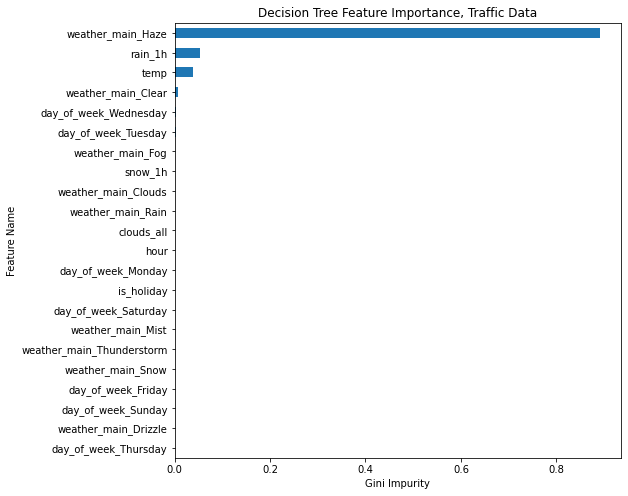

In [40]:
# standard case

print(best_model_dtr_0.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_dtr_0.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [41]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,12,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(25,35,3)).astype(int)}

# best params
param_grid = {'decisiontreeregressor__max_depth':[12], 
              'decisiontreeregressor__min_samples_leaf':[35]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_1 = grid_dtr.best_estimator_

# train_rmse_dtr_1, test_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_dtr_1, test_rmse_dtr_1, extrapolation_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9295


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=12, min_samples_leaf=35, random_state=12)
Train set RMSE:  416.4599
Test set RMSE:  436.8703


[9.89245703e-03 5.92993768e-04 0.00000000e+00 1.66829716e-03
 9.21157061e-01 6.03868036e-05 2.74587418e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.22450435e-03 3.16216505e-03
 2.56558881e-02 3.25779029e-02 8.97191062e-04 5.95744034e-04
 1.97335362e-04 4.34855370e-05]


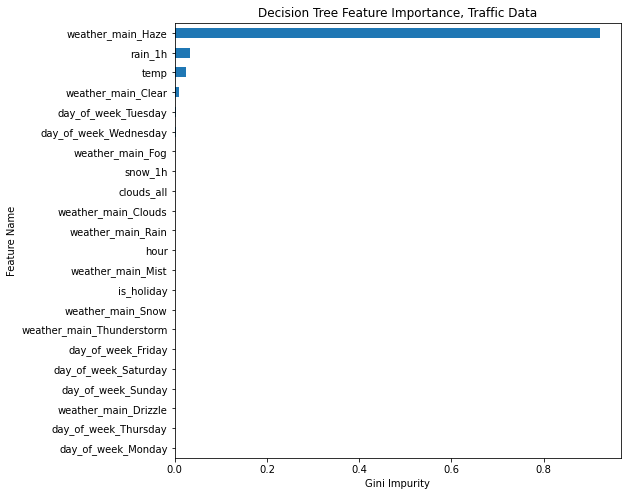

In [42]:
# first case

print(best_model_dtr_1.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_dtr_1.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [43]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,12,5)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(20,35,4)).astype(int)}

# best params
param_grid = {'decisiontreeregressor__max_depth':[12], 
              'decisiontreeregressor__min_samples_leaf':[25]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_2 = grid_dtr.best_estimator_

# train_rmse_dtr_2, test_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_dtr_2, test_rmse_dtr_2, extrapolation_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9232


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=12, min_samples_leaf=25, random_state=12)
Train set RMSE:  391.3512
Test set RMSE:  403.0153


[1.19774573e-02 1.20705093e-03 0.00000000e+00 1.78236135e-03
 9.18056672e-01 3.63075924e-05 8.62621075e-04 0.00000000e+00
 4.94153113e-04 1.93297397e-04 9.55641838e-06 0.00000000e+00
 4.40066937e-05 0.00000000e+00 4.23225180e-03 2.70886611e-03
 2.56901705e-02 3.01382547e-02 1.43709295e-03 5.41976749e-04
 5.50466809e-04 3.74368227e-05]


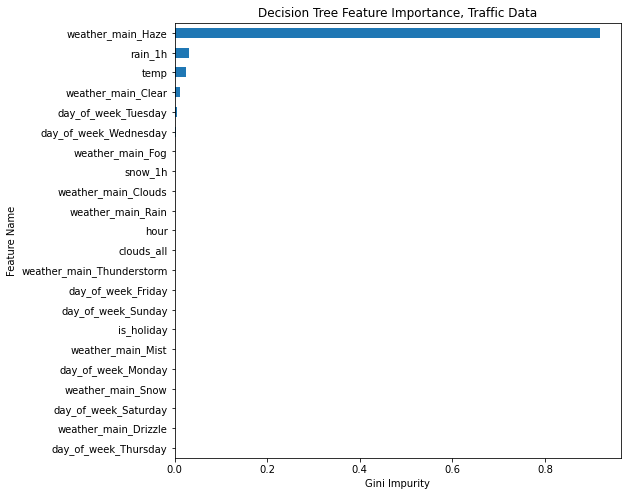

In [44]:
# second case

print(best_model_dtr_2.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_dtr_2.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [45]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,10,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(30,40,5)).astype(int)}

# best params
param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[38]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_3 = grid_dtr.best_estimator_

# train_rmse_dtr_3, test_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_dtr_3, test_rmse_dtr_3, extrapolation_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9081


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=38, random_state=12)
Train set RMSE:  375.5524
Test set RMSE:  394.9190


[9.82793999e-03 1.24148530e-03 0.00000000e+00 8.50398815e-04
 9.10326435e-01 1.52700108e-04 2.66039325e-04 0.00000000e+00
 4.62467277e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.52785536e-05 0.00000000e+00 6.55767404e-03 4.25112725e-03
 2.72961855e-02 3.57389864e-02 1.85753349e-03 6.72663305e-04
 3.91914514e-04 5.11710522e-05]


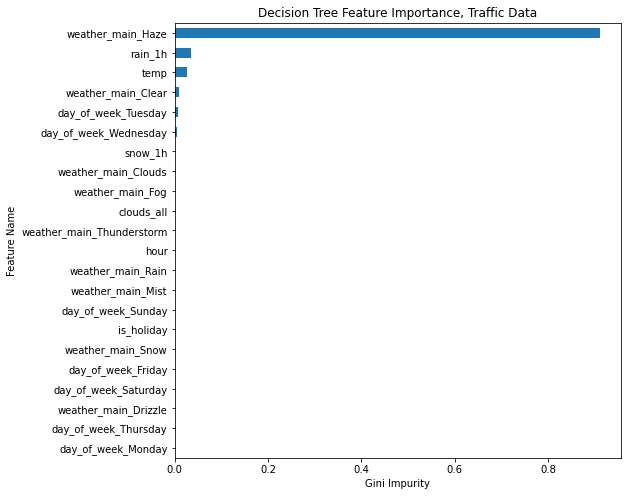

In [46]:
# third case

print(best_model_dtr_3.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + bool_feats

pd.Series(best_model_dtr_3.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Traffic Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


### 5.4 Gradient Boosting Regressor

In [47]:
# define the model

hgbr_model = HistGradientBoostingRegressor(loss='squared_error', random_state=12)
pipe_hgbr = make_pipeline(my_preprocessor, hgbr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)

In [48]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'histgradientboostingregressor__learning_rate':np.linspace(.06, .075, 5), 
#               'histgradientboostingregressor__max_iter':np.linspace(90, 115, 4).astype(int),
#               'histgradientboostingregressor__min_samples_leaf':np.round(np.linspace(20, 30, 5)).astype(int)}

# best params
param_grid = {'histgradientboostingregressor__learning_rate': [0.075], 
              'histgradientboostingregressor__max_iter':[115],
              'histgradientboostingregressor__min_samples_leaf':[20]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_0 = grid_hgbr.best_estimator_


# train_rmse_hgbr_0, test_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_hgbr_0, test_rmse_hgbr_0, extrapolation_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9385
Best parameters: {'histgradientboostingregressor__learning_rate': 0.075, 'histgradientboostingregressor__max_iter': 115, 'histgradientboostingregressor__min_samples_leaf': 20}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.075, max_iter=115,
                              random_state=12)
Train set RMSE:  424.2934
Test set RMSE:  449.9020


In [49]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'histgradientboostingregressor__learning_rate':np.linspace(.065, .075, 6), 
#               'histgradientboostingregressor__max_iter':np.linspace(80, 105, 6).astype(int),
#               'histgradientboostingregressor__min_samples_leaf':np.round(np.linspace(15, 30, 4)).astype(int)}

# best params
param_grid = {'histgradientboostingregressor__learning_rate': [0.073], 
              'histgradientboostingregressor__max_iter':[105],
              'histgradientboostingregressor__min_samples_leaf':[15]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_1 = grid_hgbr.best_estimator_


# train_rmse_hgbr_1, test_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_hgbr_1, test_rmse_hgbr_1, extrapolation_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9370
Best parameters: {'histgradientboostingregressor__learning_rate': 0.073, 'histgradientboostingregressor__max_iter': 105, 'histgradientboostingregressor__min_samples_leaf': 15}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.073, max_iter=105,
                              min_samples_leaf=15, random_state=12)
Train set RMSE:  392.4305
Test set RMSE:  412.5116


In [50]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'histgradientboostingregressor__learning_rate':np.linspace(.07, .08, 4), 
#               'histgradientboostingregressor__max_iter':np.linspace(90, 120, 4).astype(int),
#               'histgradientboostingregressor__min_samples_leaf':np.round(np.linspace(16, 26, 3)).astype(int)}

# best params
param_grid = {'histgradientboostingregressor__learning_rate': [0.07666666666666667], 
              'histgradientboostingregressor__max_iter':[120],
              'histgradientboostingregressor__min_samples_leaf':[16]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_2 = grid_hgbr.best_estimator_


# train_rmse_hgbr_2, test_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_hgbr_2, test_rmse_hgbr_2, extrapolation_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9308
Best parameters: {'histgradientboostingregressor__learning_rate': 0.07666666666666667, 'histgradientboostingregressor__max_iter': 120, 'histgradientboostingregressor__min_samples_leaf': 16}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.07666666666666667, max_iter=120,
                              min_samples_leaf=16, random_state=12)
Train set RMSE:  367.0652
Test set RMSE:  378.9530


In [51]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'histgradientboostingregressor__learning_rate':np.linspace(.055, .065, 4), 
#               'histgradientboostingregressor__max_iter':np.linspace(60, 75, 4).astype(int),
#               'histgradientboostingregressor__min_samples_leaf':np.round(np.linspace(16, 26, 3)).astype(int)}

# best params
param_grid = {'histgradientboostingregressor__learning_rate': [0.065], 
              'histgradientboostingregressor__max_iter':[75],
              'histgradientboostingregressor__min_samples_leaf':[16]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_3 = grid_hgbr.best_estimator_


# train_rmse_hgbr_3, test_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_hgbr_3, test_rmse_hgbr_3, extrapolation_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9177
Best parameters: {'histgradientboostingregressor__learning_rate': 0.065, 'histgradientboostingregressor__max_iter': 75, 'histgradientboostingregressor__min_samples_leaf': 16}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.065, max_iter=75,
                              min_samples_leaf=16, random_state=12)
Train set RMSE:  352.9779
Test set RMSE:  378.6954


# 6.0 Save RMSE Values for Plotting
- Add all RMSE values to a dictionary to simplify plotting

In [52]:
# define dictionaries for the evaluations and visualizations

rmse_0 = {'Train':         [        train_rmse_lr_0,          train_rmse_rfr_0,         train_rmse_dtr_0,         train_rmse_hgbr_0], 
          'Test':          [         test_rmse_lr_0,           test_rmse_rfr_0,          test_rmse_dtr_0,          test_rmse_hgbr_0], 
          'Extrapolation': [extrapolation_rmse_lr_0,  extrapolation_rmse_rfr_0, extrapolation_rmse_dtr_0, extrapolation_rmse_hgbr_0]}

rmse_1 = {'Train':         [        train_rmse_lr_1,          train_rmse_rfr_1,         train_rmse_dtr_1,         train_rmse_hgbr_1], 
          'Test':          [         test_rmse_lr_1,           test_rmse_rfr_1,          test_rmse_dtr_1,          test_rmse_hgbr_1], 
          'Extrapolation': [extrapolation_rmse_lr_1,  extrapolation_rmse_rfr_1, extrapolation_rmse_dtr_1, extrapolation_rmse_hgbr_1]}

rmse_2 = {'Train':         [        train_rmse_lr_2,          train_rmse_rfr_2,         train_rmse_dtr_2,         train_rmse_hgbr_2], 
          'Test':          [         test_rmse_lr_2,           test_rmse_rfr_2,          test_rmse_dtr_2,          test_rmse_hgbr_2], 
          'Extrapolation': [extrapolation_rmse_lr_2,  extrapolation_rmse_rfr_2, extrapolation_rmse_dtr_2, extrapolation_rmse_hgbr_2]}

rmse_3 = {'Train':         [        train_rmse_lr_3,          train_rmse_rfr_3,         train_rmse_dtr_3,         train_rmse_hgbr_3], 
          'Test':          [         test_rmse_lr_3,           test_rmse_rfr_3,          test_rmse_dtr_3,          test_rmse_hgbr_3], 
          'Extrapolation': [extrapolation_rmse_lr_3,  extrapolation_rmse_rfr_3, extrapolation_rmse_dtr_3, extrapolation_rmse_hgbr_3]}



# 7.0 Visualizations

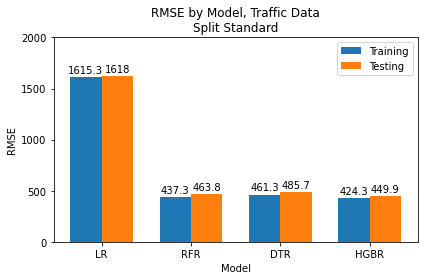

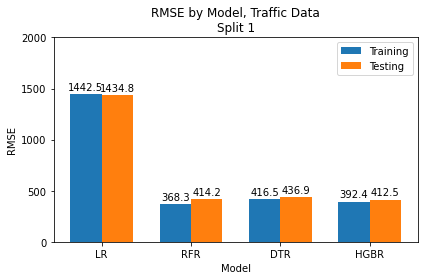

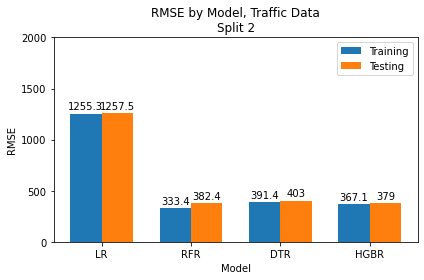

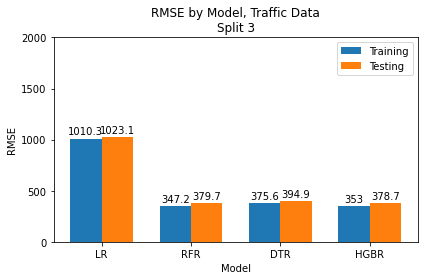

In [53]:
# plot RMSE of predictions on train and test

plot_rmse_train_test(rmse_0, 'Standard')
plot_rmse_train_test(rmse_1, 1)
plot_rmse_train_test(rmse_2, 2)
plot_rmse_train_test(rmse_3, 3)

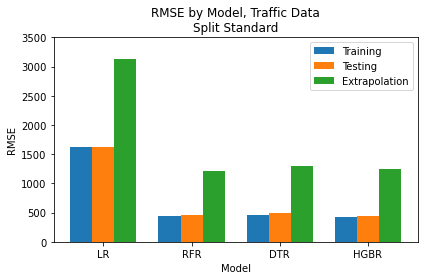

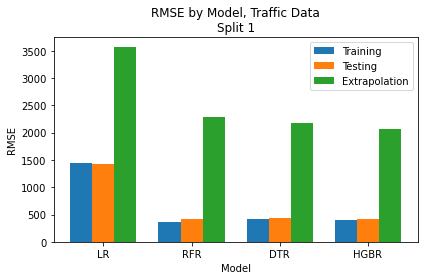

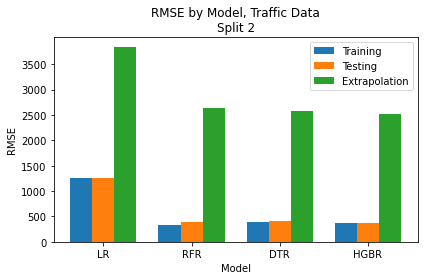

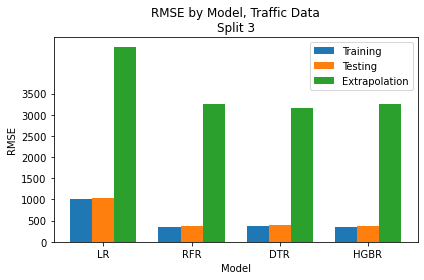

In [54]:
# plot RMSE of predictions on train, test, and extrapolation


plot_rmse_train_test_extrap(rmse_0, 'Standard')
plot_rmse_train_test_extrap(rmse_1, 1)
plot_rmse_train_test_extrap(rmse_2, 2)
plot_rmse_train_test_extrap(rmse_3, 3)

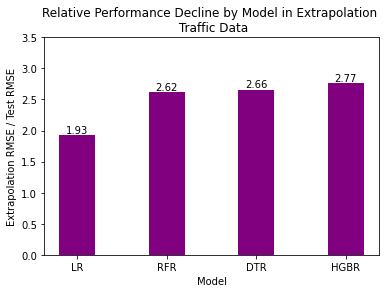

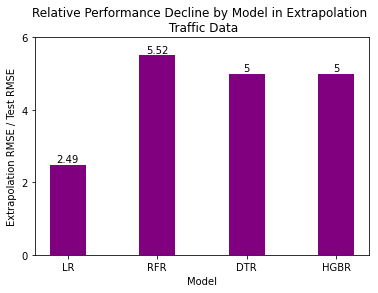

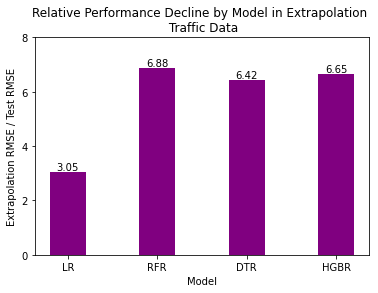

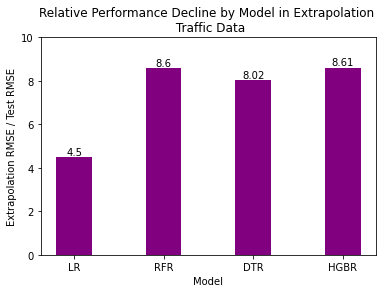

In [55]:
# plot relative difference of RMSE between extrapolation and test

plot_relative_perf(rmse_0, 'Traffic Data')
plot_relative_perf(rmse_1, 'Traffic Data', np.arange(0,8,2))
plot_relative_perf(rmse_2, 'Traffic Data', np.arange(0,10,2))
plot_relative_perf(rmse_3, 'Traffic Data', np.arange(0,12,2))

In [56]:
print('DONE!')

DONE!
